In [1]:
import cv2 
from matplotlib import pyplot as plt

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import random
import os
import csv
import cv2
from frame import FLCDataset, visualize_transformed_image


In [3]:
train_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc\train.csv", r"C:\Users\lucyc\Desktop\face_loc\train")
val_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc\val.csv", r"C:\Users\lucyc\Desktop\face_loc\val")
test_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc\test.csv", r"C:\Users\lucyc\Desktop\face_loc\test")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

In [4]:
a, b, c = next(iter(val_loader))

In [5]:
a.shape

torch.Size([32, 3, 12, 12])

In [6]:
def get_args(b):
    return [int(float(x)//1) for x in b.split()]

In [7]:
#visualize_transformed_image(a[6],get_args(b[6]),get_args(b[6]))

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
torch.cuda.empty_cache()

cuda:0


In [9]:
class PNet(nn.Module):

    def __init__(self):
        super(PNet, self).__init__()

        # 定义网络层
        self.conv1 = nn.Conv2d(3, 10, 3)  #12 -> 10 -> maxp -> 5
        self.conv2 = nn.Conv2d(10, 16, 3) #5 -> 3
        self.conv3 = nn.Conv2d(16, 32, 3) #3 -> 1

        self.face_det = nn.Conv2d(32, 2, 1) #1 -> 1
        self.bbox = nn.Conv2d(32, 4, 1) #1 -> 1
        self.landmark = nn.Conv2d(32, 10, 1) #1 -> 1

    def forward(self, x):
        # 定义前向传播
        x = F.relu(self.conv1(x)) #10
        x = F.max_pool2d(x, 2) #5
        x = F.relu(self.conv2(x)) #3
        x = F.relu(self.conv3(x)) #1

        facedet = F.relu(self.face_det(x))
        bbox = F.relu(self.bbox(x))
        landmark = F.relu(self.landmark(x))

        facedet = torch.flatten(facedet, 1)
        bbox = torch.flatten(bbox, 1)
        landmark = torch.flatten(landmark, 1)

        return facedet, bbox, landmark


In [29]:
class PNetLoss(nn.Module):
    def __init__(self):
        super(PNetLoss, self).__init__()
        # 初始化可以在这里完成，如果有必要的话

    def forward(self, facedet, bbox, landmark, label, ltypes):
        # 假设 'device' 是一个全局变量或已经事先定义好的
        loss_total = torch.tensor(0.0, device=device, requires_grad=True)
        
        for i, ltype in enumerate(ltypes):
            
            if ltype == "2":
                # 对于类型2，只需要面部检测损失
                # 一个两个元素的tensor
                face = torch.tensor([1.0, 0.0], device=device)
                facedet_loss = torch.mean(abs(facedet - face))

                loss_total = loss_total + facedet_loss

            elif ltype in ["1", "0"]:
                # 对于类型1和0，计算边界框损失
                face = torch.tensor([0.0, 1.0], device=device)
                facedet_loss = torch.mean(abs(facedet - face))

                bbox_loss = torch.mean(F.mse_loss(bbox[i], label[i][:4]))

                loss_total = loss_total + (0.5 * bbox_loss + facedet_loss)

            elif ltype == "3":
                # 对于类型3，计算关键点损失
                face = torch.tensor([0.0, 1.0], device=device)
                facedet_loss = torch.mean(abs(facedet - face))

                landmark_loss = torch.mean(F.mse_loss(landmark[i], label[i]))
                
                loss_total = loss_total + (0.5 * landmark_loss + facedet_loss)

        #loss_total = loss_total / len(ltypes)
        loss_total = loss_total
        
        return loss_total

In [34]:
class PNetLossFace(nn.Module):
    def __init__(self):
        super(PNetLossFace, self).__init__()
        # 初始化可以在这里完成，如果有必要的话

    def forward(self, facedet, bbox, landmark, label, ltypes):
        # 假设 'device' 是一个全局变量或已经事先定义好的
        loss_total = torch.tensor(0.0, device=device, requires_grad=True)
        
        for i, ltype in enumerate(ltypes):
            
            if ltype == "2":
                # 对于类型2，只需要面部检测损失
                # 一个两个元素的tensor
                face = torch.tensor([1.0, 0.0], device=device)
                facedet_loss = torch.mean(abs(facedet - face))

                loss_total = loss_total + facedet_loss

            elif ltype in ["1", "0"]:
                # 对于类型1和0，计算边界框损失
                face = torch.tensor([0.0, 1.0], device=device)
                facedet_loss = torch.mean(abs(facedet - face))

                bbox_loss = torch.mean(F.mse_loss(bbox[i], label[i][:4]))

                loss_total = loss_total + (0 * bbox_loss + facedet_loss)

            elif ltype == "3":
                # 对于类型3，计算关键点损失
                face = torch.tensor([0.0, 1.0], device=device)
                facedet_loss = torch.mean(abs(facedet - face))

                landmark_loss = torch.mean(F.mse_loss(landmark[i], label[i]))
                
                loss_total = loss_total + (0 * landmark_loss + facedet_loss)

        #loss_total = loss_total / len(ltypes)
        loss_total = loss_total
        
        return loss_total

In [39]:
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

model = PNet()
print(model)

model.to(device)  # 将模型发送到GPU，如果有的话

# 定义损失函数和优化器
criterion = PNetLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


PNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (face_det): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  (bbox): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  (landmark): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1))
)


In [40]:
model.train()  # 设置模型为训练模式

train_x = []
train_loss_y = []

train_loss_acc = 0.
train_num = 0

for inputs in train_loader:
    
    img_tensor = inputs[0].to(device)
    label = inputs[1].to(device)
    ltypes = inputs[2]

    facedet, bbox, landmark = model(img_tensor)
    optimizer.zero_grad()  # 清除之前的梯度
    loss = criterion(facedet, bbox, landmark, label, ltypes)
    # 反向传播和优化
    loss.backward()  # 反向传播计算当前的梯度
    optimizer.step()  # 更新参数

    train_loss_acc += loss.item()
    train_num += 1

    train_x.append(train_num)
    train_loss_y.append(loss.item())
    
    print(train_num,loss.item(),sum(train_loss_y[-200:])/200, train_num*32, len(train_dataset))
    

1 814.393798828125 4.071968994140625 32 130000
2 718.4366455078125 7.664152221679688 64 130000
3 664.851318359375 10.988408813476562 96 130000
4 670.1790771484375 14.33930419921875 128 130000
5 635.7699584960938 17.51815399169922 160 130000
6 666.6062622070312 20.851185302734375 192 130000
7 639.2164306640625 24.047267456054687 224 130000
8 582.8231201171875 26.961383056640624 256 130000
9 722.7825317382812 30.575295715332032 288 130000
10 690.4308471679688 34.027449951171874 320 130000
11 666.7760620117188 37.36133026123047 352 130000
12 883.1041259765625 41.776850891113284 384 130000
13 718.57177734375 45.36970977783203 416 130000
14 625.2865600585938 48.496142578125 448 130000
15 675.7346801757812 51.874815979003905 480 130000
16 545.1529541015625 54.60058074951172 512 130000
17 798.4953002929688 58.593057250976564 544 130000
18 672.6820678710938 61.95646759033203 576 130000
19 532.7737426757812 64.62033630371094 608 130000
20 600.5999755859375 67.62333618164062 640 130000
21 705.17

In [ ]:
# 验证多任务训练在 单一任务上的表现 是否有提升
# 单任务 全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 8.135152058410645
# 多任务 全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 8.84007318687439

In [41]:

criterion = PNetLossFace()

model.eval() 
val_loss_acc = 0
val_num = 0
with torch.no_grad():
    for inputs in val_loader:
        img_tensor = inputs[0].to(device)
        label = inputs[1].to(device)
        ltypes = inputs[2]

        facedet, bbox, landmark = model(img_tensor)
        loss = criterion(facedet, bbox, landmark, label, ltypes)

        val_loss_acc += loss.item()
        val_num += 1

        print(val_num,loss.item(),val_loss_acc/val_num, val_num*32, len(val_dataset))

print("val loss avg:", val_loss_acc/val_num)


1 7.753943920135498 7.753943920135498 32 19999
2 12.787479400634766 10.270711660385132 64 19999
3 6.804238319396973 9.115220546722412 96 19999
4 8.903679847717285 9.06233537197113 128 19999
5 10.772705078125 9.404409313201905 160 19999
6 9.694016456604004 9.452677170435587 192 19999
7 8.063899993896484 9.25428043093 224 19999
8 11.735485076904297 9.564431011676788 256 19999
9 7.866039276123047 9.375720818837484 288 19999
10 7.000204086303711 9.138169145584106 320 19999
11 10.692322731018066 9.279455835169012 352 19999
12 12.654272079467773 9.560690522193909 384 19999
13 10.728946685791016 9.650556380932148 416 19999
14 11.51103687286377 9.783447844641548 448 19999
15 4.204728603363037 9.411533228556316 480 19999
16 6.929529666900635 9.256408005952835 512 19999
17 5.938549995422363 9.061239887686337 544 19999
18 8.873330116271973 9.050800455941094 576 19999
19 7.728356838226318 8.981198160271896 608 19999
20 4.782381057739258 8.771257305145264 640 19999
21 7.889349937438965 8.7292617162

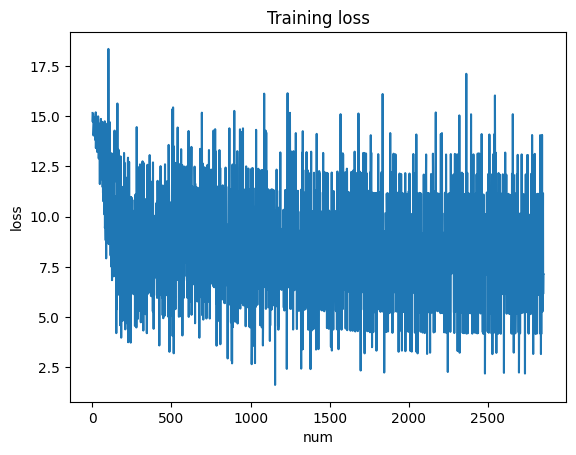

In [28]:
# draw loss curve
plt.plot(train_x, train_loss_y, label='train')
plt.xlabel('num')
plt.ylabel('loss')
plt.title('Training loss')
plt.show()



In [ ]:
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

model = PNet()
print(model)

model.to(device)  # 将模型发送到GPU，如果有的话

# 定义损失函数和优化器
criterion = PNetLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 训练模型
num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式

    train_x = []
    train_loss_y = []

    train_loss_acc = 0.
    train_num = 0

    for inputs in train_loader:
        
        img_tensor = inputs[0].to(device)
        label = inputs[1].to(device)
        ltypes = inputs[2]

        facedet, bbox, landmark = model(img_tensor)
        optimizer.zero_grad()  # 清除之前的梯度
        loss = criterion(facedet, bbox, landmark, label, ltypes)
        # 反向传播和优化
        loss.backward()  # 反向传播计算当前的梯度
        optimizer.step()  # 更新参数

        train_loss_acc += loss.item()
        train_num += 1

        train_x.append(train_num)
        train_loss_y.append(loss.item())
        print(train_num,loss.item(),sum(train_loss_y[-200:])/200, train_num*32, len(train_dataset))

    model.eval() 
    val_loss_acc = 0
    val_num = 0
    with torch.no_grad():
        for inputs in val_loader:
            img_tensor = inputs[0].to(device)
            label = inputs[1].to(device)
            ltypes = inputs[2]

            facedet, bbox, landmark = model(img_tensor)
            loss = criterion(facedet, bbox, landmark, label, ltypes)

            val_loss_acc += loss.item()
            val_num += 1

            print(val_num,loss.item(),val_loss_acc/val_num, val_num*32, len(train_dataset))

    print("Epoch [{}/{}], Loss: {:.2f}, Val_loss: {:.2f}".format(epoch+1, num_epochs, val_loss_acc/val_num, val_loss_acc/val_num))

    # draw loss curve
    plt.plot(train_x, train_loss_y, label='train')
    plt.xlabel('num')
    plt.ylabel('loss')
    plt.title('Training loss')
    plt.show()
    
    input("Press Enter to continue...")
